## Curve-Fitting comparison: Python and Mathematica

+ Implementation of curve-fitting in Python.<br>
+ Starting point: version of mlr.py written for PHYS 310 Jack Gallimore.<br>
+ Comments based on treatment in Numerical Recipes (Chapter 14.3 in my copy).<br>
+ Compare with results of Mathematica for same data sets: see pythonTest.nb.

Define function that is a linear combination of  "Basis Functions," $X_k(x)$, evaluated at all values of independent variable $x_j$ -- see Eq. (14.3.2) in Numerical Recipes.  These are combined into the single matrix that gets weighted for the illustrated matrix in Fig. 14.3.1 of Numerical Recipes.

Covariance Matrix; See Eq. (14.3.8), and following discussion:

$$\alpha_{kj} = \sum_{i=1}^N\frac{X_j(x_i)X_k(x_i)}{\sigma_i^2} \hspace{0.2in}\mbox{and}
             \hspace{0.2in}C_{jk} = [\alpha]_{jk}^{-1}$$

This result gives covariance matrix if uncertainties are measurement uncertainties with well-known values.  To get covariance matrix from uncertainties estimated from observed spread of values, multiply $C_{jk}$ by $\chi_R^2$. 

### Linear fitting 

In [1]:
import scipy as sp
from scipy.linalg import inv, lstsq

import matplotlib as mpl       # As of July 2017 Bucknell computers use v. 2.x 
import matplotlib.pyplot as plt

# Following is an Ipython magic command that puts figures in the  notebook.
# For figures in separate windows, comment out following line and uncomment
# the next line
# Must come before defaults are changed.
%matplotlib notebook
#%matplotlib

# As of Aug. 2017 reverting to 1.x defaults.
# In 2.x text.ustex requires dvipng, texlive-latex-extra, and texlive-fonts-recommended, 
# which don't seem to be universal
# See https://stackoverflow.com/questions/38906356/error-running-matplotlib-in-latex-type1cm?
mpl.style.use('classic')
        
# M.L. modifications of matplotlib defaults using syntax of v.2.0 
# More info at http://matplotlib.org/2.0.0/users/deflt_style_changes.html
# Changes can also be put in matplotlibrc file, or effected using mpl.rcParams[]
plt.rc('figure', figsize = (6, 4.5))            # Reduces overall size of figures
plt.rc('axes', labelsize=16, titlesize=14)
plt.rc('figure', autolayout = True)             # Adjusts supblot parameters for new size

### THE FOLLOWING CELL DEFINING BASIS FUNCTIONS IS ONLY FUNCTION CELL THAT SHOULD REQUIRE MODIFICATION FOR NEW MODEL

In [2]:
# Basis functions for linear model:  func = a0*X0 + a1*X1 + a2*X2 + ...
def basis(x):
    ''' Returns basis functions for linear model
    
    The function to be fit is assumed to be of the form
    f(x) = a0*X0 + a1*X1 + a2*X2 + a3*X3 + ...
    where a0, a1, a2, ... are constants, and X0, X1, X2, ... are defined below.
    '''
    X2 = x**2   
    X1 = x
    X0 = 0.*X1 + 1. # Need array of len(x), thus the 0.*X1
    return sp.array([X0,X1,X2])

#### Evaluate function that is a linear combination of basis functions, with cofficients contained in array `a`

In [3]:
def func(x, a):
    '''Given basis functions and coefficients, returns value of linear function'''
    return sp.dot(basis(x).T, a)

#### Function that does fitting, and formats output:

In [4]:
def LinearModelFit(x, y, u):
    '''Performs linear least squares fit to a set of 2-d data with uncertainties
    
    x = array of x values [x0, x1, x2, ...]
    y = array of values of dependent variable [y0, y1, y2, ...]
    u = array of uncertainties for dependent variable [u0, u1, u2, ...]
    '''
    X = basis(x).T    # Basis functions evaluated at all x (the X_j(x_i)) of N.R.)
    W = sp.diag(1/u)  # Matrix with uncertainties on diagonal
    Xw = sp.dot(W,X)  # A_ij of Eq. (14.3.4)
    Yw = sp.dot(y,W)  # b_i of Eq. (14.3.5)
    fit = sp.linalg.lstsq(Xw,Yw)  # lstq returns: best values, chi2, ....
    covariance = sp.linalg.inv(sp.dot(Xw.T,Xw))
    uncertainty = sp.sqrt(sp.diag(covariance))
    return(fit[0], uncertainty,fit[1], covariance)

Generate some noisy data (x,y) with uncertainties u, or import sample data file.

In [5]:
# Cell for generating data; overwritten by following cell if data is coming from file.
x = sp.linspace(0, 10, 11)
sigma = 5.0
a = sp.array([1.2, 3.4, -0.9])
y = func(x,a) + sp.random.normal(0, sigma, size=len(x))
u = sigma*sp.ones(len(y))
#sp.savetxt("sample.dat",sp.array([x,y,u]).T)

In [6]:
data = sp.loadtxt("sample.dat")  #Each line in file corresponds single data point: x,y,u

In [7]:
x = data.T[0]
y = data.T[1]
u = data.T[2]

Two previous cells would be more "pythonic" as

    x, y, u = sp.loadtxt("sample.dat", unpack=True)

The "unpack = True" reads columns.

In [8]:
x, y, u = sp.loadtxt("sample.dat", unpack=True)

<IPython.core.display.Javascript object>


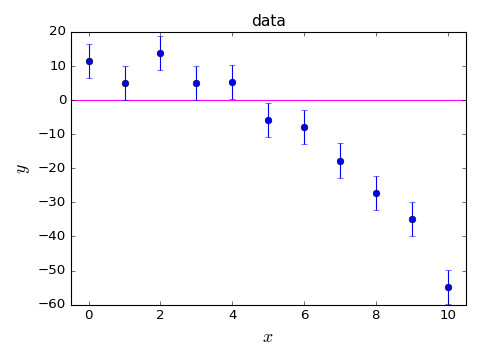

In [9]:
plt.figure(1)
plt.axhline(0, color='magenta')
plt.title("data")
plt.xlabel('$x$')
plt.ylabel('$y$')
plt.xlim(min(x)-0.05*(max(x)-min(x)), max(x)+ 0.05*(max(x)-min(x)))  # Pad x-range on plot
plt.errorbar(x, y, yerr=u, fmt='o');

### Do the fitting
#### Returns:
+ `a`, array of coefficents of basis functions
+ `unc`, array of uncertainties in coefficients
+ `chi2`, value of $\chi^2$ (not reduced)
+ `cov`, covariance matrix

In [10]:
a, unc, chi2, cov = LinearModelFit(x,y,u)
a, unc, chi2, cov

(array([ 9.28889248,  1.52600889, -0.7646087 ]),
 array([ 3.80926364,  1.77229389,  0.17069719]),
 4.0374969737005344,
 array([[ 14.51048951,  -5.50699301,   0.43706294],
        [ -5.50699301,   3.14102564,  -0.29137529],
        [  0.43706294,  -0.29137529,   0.02913753]]))

#### Results:

In [11]:
for i in range(len(a)):
    print("parameter", i,"=", a[i],"+/-", sp.sqrt(cov[i,i]))
print("chi2 =", chi2)
print("reduced chi2 = chi2/(11-3) =", chi2/8)

parameter 0 = 9.28889248407 +/- 3.80926364413
parameter 1 = 1.52600889077 +/- 1.7722938924
parameter 2 = -0.764608697445 +/- 0.1706971855
chi2 = 4.0374969737
reduced chi2 = chi2/(11-3) = 0.504687121713


<IPython.core.display.Javascript object>


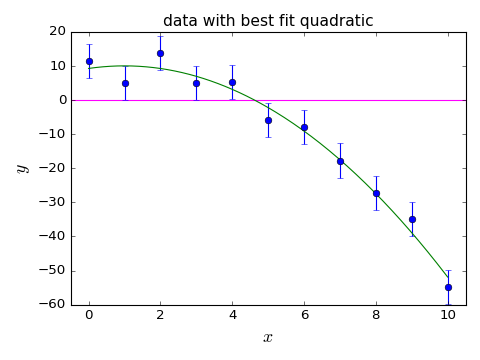

In [12]:
xfine = sp.linspace(min(x), max(x), 201)  # "quasi-continuous" set of x's for plotting function
plt.figure(2)
plt.title("data with best fit quadratic",fontsize=14)
plt.xlabel('$x$')
plt.ylabel('$y$')
plt.axhline(0, color='magenta')
plt.xlim(min(x)-0.05*(max(x)-min(x)), max(x)+ 0.05*(max(x)-min(x)))  # Pad x-range on plot
plt.errorbar(x, y, yerr=u, fmt='o')
plt.plot(xfine, func(xfine, a));

#### Residuals:

<IPython.core.display.Javascript object>


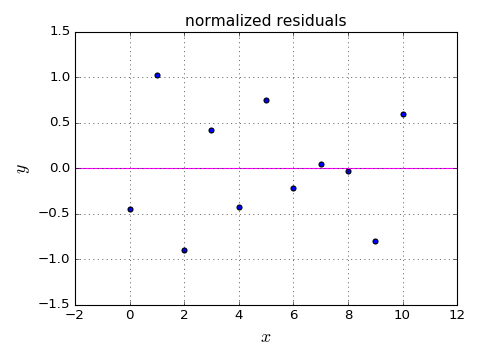

In [13]:
plt.figure(3)
plt.axhline(0, color='magenta')
plt.title('normalized residuals')
plt.xlabel('$x$')
plt.ylabel('$y$')
plt.grid()
plt.scatter(x,(func(x,a)-y)/u);


#### Check $\chi_R^2$:

Explicit calculation of reduced chi-square parameter:

\begin{equation}
\chi_R^2= \frac{1}{N-c}\times\sum_{i=1}^N \frac{(y_i-f(x_i))^2}{\sigma_i^2}, 
\end{equation}

and compare with return value from `lstsq`.

In [14]:
sp.sum((y-func(x,a))**2/u**2)/(len(x)-3)

0.50468712171256791

### Version details

`version_information` is from J.R. Johansson (jrjohansson at gmail.com)<br>
See Introduction to scientific computing with Python:<br>
http://nbviewer.jupyter.org/github/jrjohansson/scientific-python-lectures/blob/master/Lecture-0-Scientific-Computing-with-Python.ipynb <br>
for more information and instructions for package installation.<br>

If `version_information` has been installed system wide (as it has been on Bucknell linux computers with shared file systems), continue with next cell as written.  If not, comment out top line in next cell and uncomment the second line.

In [15]:
%load_ext version_information

#%install_ext http://raw.github.com/jrjohansson/version_information/master/version_information.py

Loading extensions from ~/.ipython/extensions is deprecated. We recommend managing extensions like any other Python packages, in site-packages.


In [16]:
version_information scipy, matplotlib

Software versions
Python 3.6.1 64bit [GCC 4.4.7 20120313 (Red Hat 4.4.7-1)]
IPython 6.1.0
OS Linux 3.10.0 327.36.3.el7.x86_64 x86_64 with redhat 7.2 Maipo
scipy 0.19.1
matplotlib 2.0.2
Tue Aug 01 10:58:27 2017 EDT